<a href="https://colab.research.google.com/github/f-lrz/BairesDev_Files/blob/main/Sistema_de_recomenda%C3%A7%C3%B5es_por_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

# Monta o Drive no diretório '/content/drive'
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cria um arquivo chamado 'kaggle.json' com as credenciais do Kaggle
%%writefile kaggle.json
{"username":"gysellemarques","key":"bc54070008d79e0009e62fadd8e56c82"}

Writing kaggle.json


In [4]:
# Instala ou atualiza a biblioteca do Kaggle
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

# Configuração do ambiente Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [5]:
# Baixa e descompacta o conjunto de dados de imagens de moda do Kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip -q fashion-product-images-small.zip

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 96% 543M/565M [00:03<00:00, 48.0MB/s]
100% 565M/565M [00:03<00:00, 162MB/s] 


In [6]:
import os
import shutil
import random

# Definir os caminhos
image_dir = 'images'
train_dir = 'train'
val_dir = 'validation'

# Verificar se o diretório de imagens existe
if not os.path.exists(image_dir):
    print(f"Erro: O diretório {image_dir} não existe!")
    exit(1)

# Criar os diretórios de treino e validação, se não existirem
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Listar todas as imagens no diretório
try:
    images = [img for img in os.listdir(image_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        print(f"Erro: Nenhuma imagem encontrada no diretório {image_dir}!")
        exit(1)
except FileNotFoundError:
    print(f"Erro: O diretório {image_dir} não foi encontrado!")
    exit(1)

# Embaralhar as imagens
random.seed(42)
random.shuffle(images)

# Definir a proporção de treino e validação
train_ratio = 0.8
n_train = int(len(images) * train_ratio)

# Dividir as imagens em treino e validação
train_images = images[:n_train]
val_images = images[n_train:]

# Cópiar as imagens para os diretórios de treino e validação
for img in train_images:
    shutil.copy(os.path.join(image_dir, img), os.path.join(train_dir, img))

for img in val_images:
    shutil.copy(os.path.join(image_dir, img), os.path.join(val_dir, img))

print(f"Imagens de treino: {len(train_images)}")
print(f"Imagens de validação: {len(val_images)}")

Imagens de treino: 35552
Imagens de validação: 8889


In [7]:
# Configurar o ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.)

In [8]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir os caminhos das pastas
train_dir = 'train'  # Pasta com as imagens de treino
val_dir = 'validation'  # Pasta com as imagens de validação

# Criar um DataFrame para as imagens de treino
train_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir)]
train_labels = [0] * len(train_images)  # Rótulos fictícios (0 para todas as imagens)
train_df = pd.DataFrame({
    'filename': train_images,
    'class': train_labels
})

# Criar um DataFrame para as imagens de validação
val_images = [os.path.join(val_dir, img) for img in os.listdir(val_dir)]
val_labels = [0] * len(val_images)  # Rótulos fictícios (0 para todas as imagens)
val_df = pd.DataFrame({
    'filename': val_images,
    'class': val_labels
})

# Criar um gerador de dados para treino e validação
datagen = ImageDataGenerator(rescale=1./255)  # Normaliza os pixels para o intervalo [0, 1]

# Gerador de dados para treino
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',  # Coluna com os caminhos das imagens
    y_col='class',  # Coluna com os rótulos
    target_size=(60, 80),  # Redimensiona as imagens para 60x80
    batch_size=32,
    class_mode='raw',  # Usar 'raw' para rótulos numéricos
    shuffle=True  # Embaralhar as imagens
)

# Gerador de dados para validação
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',  # Coluna com os caminhos das imagens
    y_col='class',  # Coluna com os rótulos
    target_size=(60, 80),  # Redimensiona as imagens para 60x80
    batch_size=32,
    class_mode='raw',  # Usar 'raw' para rótulos numéricos
    shuffle=False  # Não embaralhar as imagens de validação
)

# Verificar os geradores
print(f"Treino: {train_generator.samples} imagens encontradas.")
print(f"Validação: {val_generator.samples} imagens encontradas.")

Found 35552 validated image filenames.
Found 8889 validated image filenames.
Treino: 35552 imagens encontradas.
Validação: 8889 imagens encontradas.


In [9]:
# Carregar o modelo base VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = VGG16(include_top=False, input_shape=(256, 256, 3))

# Construir o modelo
model = Sequential([base_model, GlobalAveragePooling2D()])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.neighbors import NearestNeighbors
import numpy as np
import os

In [11]:
# Carregar a rede VGG16 pré-treinada (sem a camada fully connected)
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

In [12]:
# Função para extrair características de uma imagem
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features.flatten()

In [13]:
# Definir as 4 imagens de referência (uma para cada classe)
reference_images = {
    "calça": "/content/images/10012.jpg",
    "camiseta": "/content/images/10465.jpg",
    "relogio": "/content/images/10580.jpg",
    "sapato": "/content/images/10111.jpg"
}

In [14]:
# Extrair características das 4 imagens de referência
reference_features = {name: extract_features(path, model) for name, path in reference_images.items()}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


In [15]:
# Função para recomendar a classe mais similar
def recommend_similar_class(query_image_path, reference_features, model):
    # Extrair características da imagem de consulta
    query_features = extract_features(query_image_path, model)

    # Calcular a similaridade (distância cosseno) com as imagens de referência
    similarities = {}
    for name, ref_features in reference_features.items():
        similarity = 1 - np.linalg.norm(query_features - ref_features)  # Distância cosseno
        similarities[name] = similarity

    # Encontrar a classe mais similar
    most_similar_class = max(similarities, key=similarities.get)
    return most_similar_class, similarities

In [16]:
# Exemplo de uso
query_image = "/content/images/11144.jpg"
most_similar_class, similarities = recommend_similar_class(query_image, reference_features, model)

print(f"A imagem de consulta é mais similar à classe: {most_similar_class}")
print("Similaridades com cada classe:", similarities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
A imagem de consulta é mais similar à classe: camiseta
Similaridades com cada classe: {'calça': np.float32(-78.74651), 'camiseta': np.float32(-60.994774), 'relogio': np.float32(-98.739815), 'sapato': np.float32(-91.178)}


In [17]:
import os
import shutil

In [18]:
import os

# Cria a pasta "img" caso ela ainda não exista
os.makedirs("img", exist_ok=True)

# Verifica se a pasta foi criada com sucesso
print("Pasta 'img' criada com sucesso!" if os.path.exists("img") else "Erro ao criar a pasta.")

Pasta 'img' criada com sucesso!


In [19]:
# Caminho da pasta original
pasta_origem = "/content/images"

# Caminho da nova pasta
pasta_destino = "/content/img"

In [20]:
# Verificar se a pasta de destino existe. Se não, criar.
if not os.path.exists(pasta_destino):
    os.makedirs(pasta_destino)

In [21]:
# Intervalo de nomes das imagens
inicio = 10005
fim = 10700

In [22]:
# Copiar as imagens no intervalo especificado
for i in range(inicio, fim + 1):
    nome_arquivo = f"{i}.jpg"  # Assumindo que as imagens são .jpg
    caminho_origem = os.path.join(pasta_origem, nome_arquivo)
    caminho_destino = os.path.join(pasta_destino, nome_arquivo)

    # Verificar se o arquivo existe na pasta de origem
    if os.path.exists(caminho_origem):
        shutil.copy(caminho_origem, caminho_destino)
        print(f"Copiado: {nome_arquivo}")
    else:
        print(f"Arquivo não encontrado: {nome_arquivo}")

Copiado: 10005.jpg
Copiado: 10006.jpg
Copiado: 10007.jpg
Copiado: 10008.jpg
Copiado: 10009.jpg
Copiado: 10010.jpg
Copiado: 10011.jpg
Copiado: 10012.jpg
Copiado: 10013.jpg
Copiado: 10014.jpg
Copiado: 10015.jpg
Copiado: 10016.jpg
Copiado: 10017.jpg
Copiado: 10018.jpg
Copiado: 10019.jpg
Copiado: 10020.jpg
Copiado: 10021.jpg
Copiado: 10022.jpg
Copiado: 10023.jpg
Copiado: 10024.jpg
Copiado: 10025.jpg
Copiado: 10026.jpg
Copiado: 10027.jpg
Copiado: 10028.jpg
Copiado: 10029.jpg
Copiado: 10030.jpg
Copiado: 10031.jpg
Copiado: 10032.jpg
Copiado: 10033.jpg
Copiado: 10034.jpg
Copiado: 10035.jpg
Arquivo não encontrado: 10036.jpg
Copiado: 10037.jpg
Arquivo não encontrado: 10038.jpg
Copiado: 10039.jpg
Copiado: 10040.jpg
Copiado: 10041.jpg
Copiado: 10042.jpg
Copiado: 10043.jpg
Copiado: 10044.jpg
Copiado: 10045.jpg
Copiado: 10046.jpg
Copiado: 10047.jpg
Copiado: 10048.jpg
Copiado: 10049.jpg
Copiado: 10050.jpg
Copiado: 10051.jpg
Copiado: 10052.jpg
Copiado: 10053.jpg
Copiado: 10054.jpg
Arquivo não encontra

In [23]:
print("Cópia concluída!")

Cópia concluída!


In [24]:
# Importar bibliotecas necessárias
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Carregar a rede VGG16 pré-treinada (sem a camada fully connected)
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

In [26]:
# Função para extrair características de uma imagem
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features.flatten()

In [27]:
# Definir as 4 imagens de referência (uma para cada classe)
reference_images = {
    "calça": "/content/images/10020.jpg",
    "camiseta": "/content/images/11163.jpg",
    "relogio": "/content/images/10241.jpg",
    "sapato": "/content/images/10110.jpg"
}

In [28]:
# Carregar o conjunto de imagens para recomendações
recommendation_image_dir = "/content/img/"
recommendation_image_paths = [os.path.join(recommendation_image_dir, img) for img in os.listdir(recommendation_image_dir)]

In [29]:
# Extrair características das imagens de referência e do conjunto de recomendações
reference_features = {name: extract_features(path, model) for name, path in reference_images.items()}
recommendation_features = [extract_features(img_path, model) for img_path in recommendation_image_paths]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [30]:
# Salvar as características em um arquivo .npy
np.save('/content/drive/MyDrive/recommendation_features.npy', recommendation_features)
np.save('/content/drive/MyDrive/reference_features.npy', list(reference_features.values()))

In [31]:
# Função para recomendar as 4 imagens mais próximas
def recommend_similar_images(query_features, recommendation_features, recommendation_image_paths):
    knn = NearestNeighbors(n_neighbors=4, metric='cosine')
    knn.fit(recommendation_features)
    distances, indices = knn.kneighbors([query_features])
    similar_images = [recommendation_image_paths[idx] for idx in indices.flatten()]
    return similar_images

In [32]:
# Função para exibir imagens
def show_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths):
        plt.subplot(1, len(image_paths), i + 1)
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [33]:
# Montar o Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Criar o diretório para salvar as imagens recomendadas
dir_path = '/content/drive/MyDrive/img_recomendada'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
Classe de referência: calça


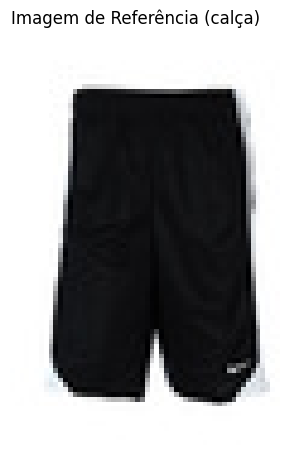

Imagens recomendadas para a classe 'calça':


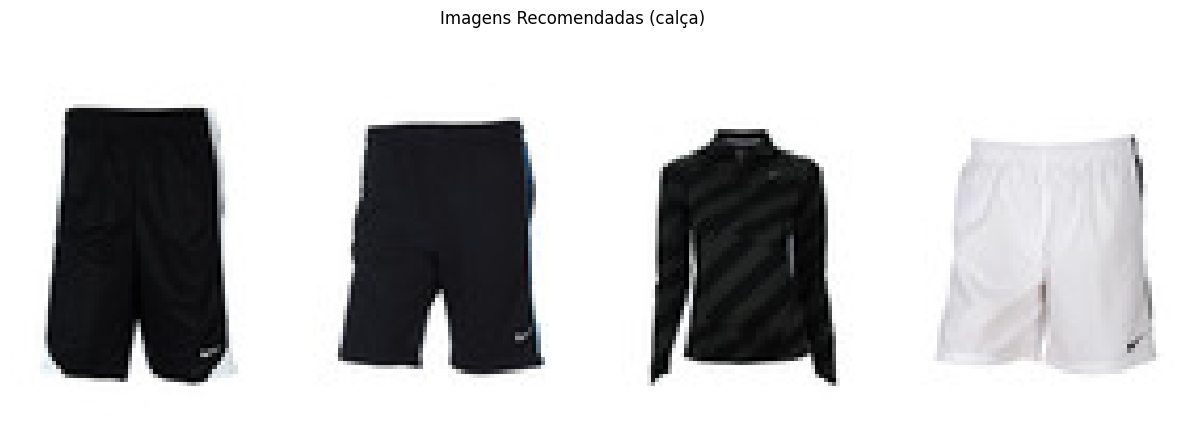

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Classe de referência: camiseta


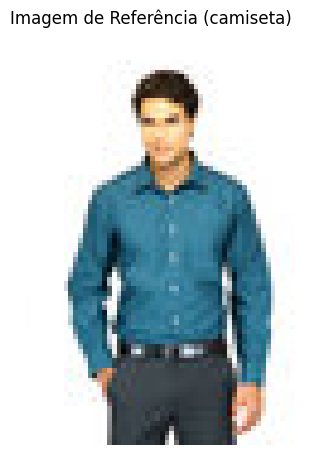

Imagens recomendadas para a classe 'camiseta':


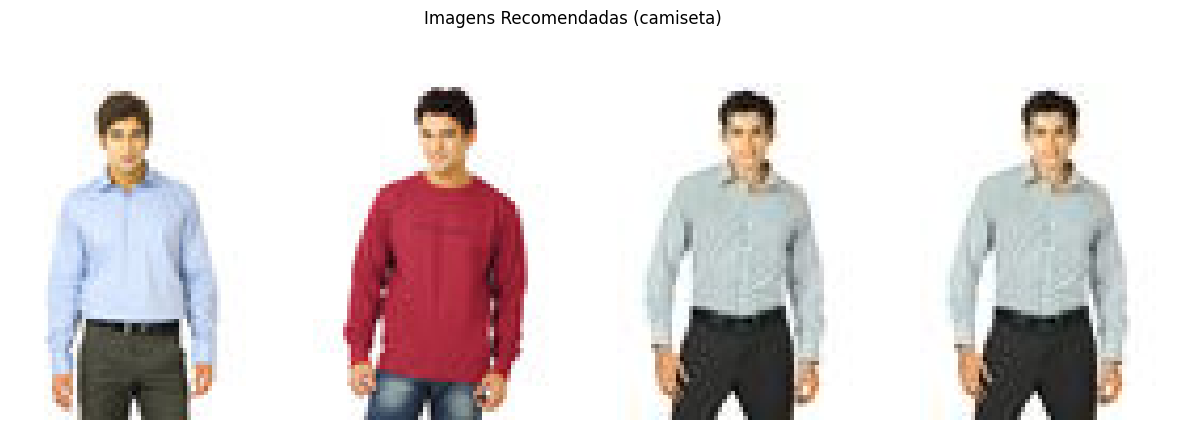

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
Classe de referência: relogio


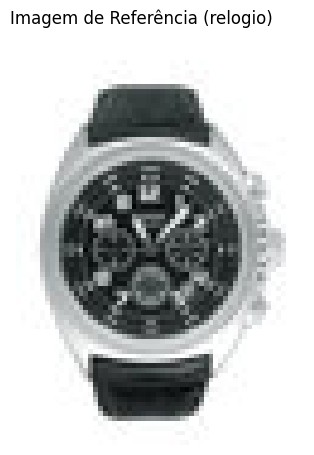

Imagens recomendadas para a classe 'relogio':


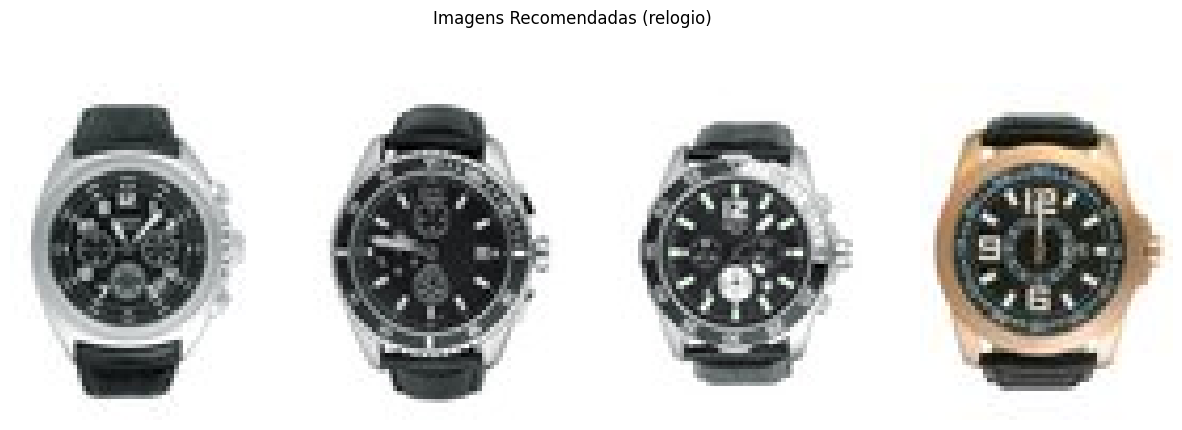

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
Classe de referência: sapato


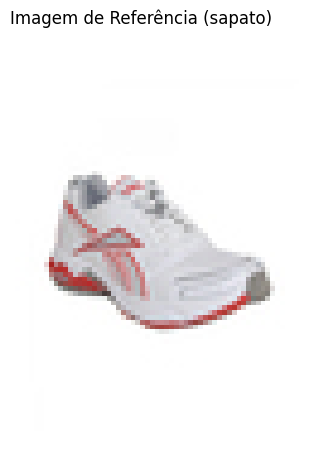

Imagens recomendadas para a classe 'sapato':


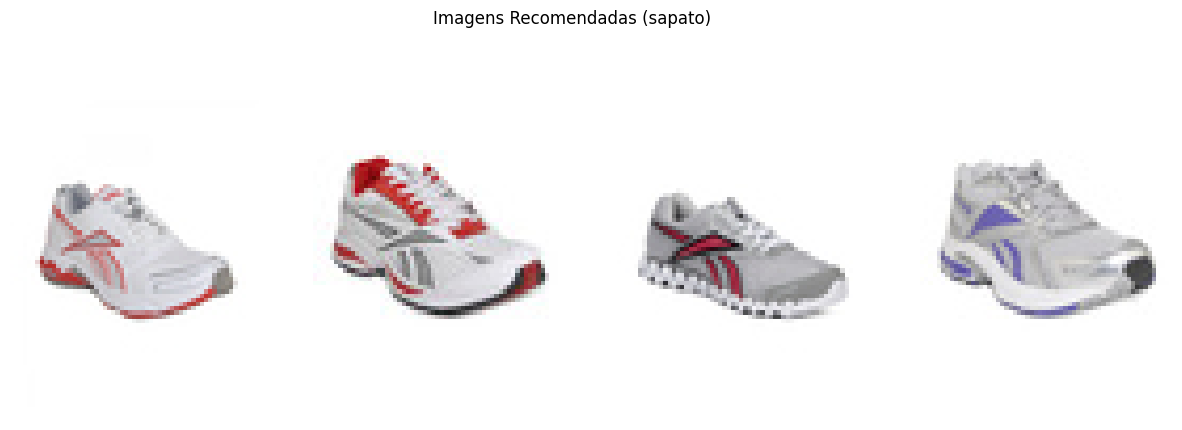

In [36]:
# Exibir recomendações para cada classe de referência
for class_name, ref_image_path in reference_images.items():
    # Extrair características da imagem de referência
    ref_features = extract_features(ref_image_path, model)

    # Encontrar as 5 imagens mais similares
    similar_images = recommend_similar_images(ref_features, recommendation_features, recommendation_image_paths)

    # Exibir a imagem de referência
    print(f"Classe de referência: {class_name}")
    show_images([ref_image_path], f"Imagem de Referência ({class_name})")

    # Exibir as 5 imagens recomendadas
    print(f"Imagens recomendadas para a classe '{class_name}':")
    show_images(similar_images, f"Imagens Recomendadas ({class_name})")